In [1]:
import pandas as pd
import hvplot.pandas
import holoviews as hv
import panel as pn
import plotly.express as px
import numpy as np
from hvplot import hvPlot
import param
from src.data.make_dataset import DATA_PATH
from src.visualization.visualize import _get_upper_bar, LABELS
from src.visualization.panel_figures import benchmark
import random

pd.options.plotting.backend = "holoviews"

%load_ext autoreload
%autoreload 2

In [2]:
df = benchmark.get_df()

In [3]:
df.columns

Index(['Id', 'SIREN principal', 'Méthode BEGES (V4,V5)', 'Type de structure',
       'Type de collectivité', 'Mode de consolidation', 'Recalcul',
       'Comparaison avec le précédent bilan', 'nb_salaries_range',
       'nb_salaries_min', 'nb_salaries_max', 'nb_salaries_mean', 'naf5',
       'Secteur d'activité (NAF1)', 'naf2', 'naf3', 'naf4',
       'month_publication', 'Année de reporting', 'Structure obligée',
       'poste_emissions', 'Émissions_totales', 'Émission_par_salarié',
       'emissions_clipped', 'Catégorie d'émissions', 'Poste d'émissions',
       'Année de publication'],
      dtype='object')

# Compare my results with the 2021 ADEME rapport

https://librairie.ademe.fr/changement-climatique-et-energie/5919-evaluation-2021-de-la-reglementation-des-bilans-d-emissions-de-gaz-a-effet-de-serre.html

L’évaluation quantitative a été réalisée sur la base des informations transmises par l’ADEME : bilans GES issus de la
plateforme, croisées avec la liste des obligés 2021, fournie par le MTE (Ministère de la Transition Ecologique). Cela concerne
2 385 bilans publiés entre 2016 et 2021 (*), dont 1 887 publiés entre 2018 et 2021. Les bilans antérieurs à 2018 sont exclus de
l’analyse car ne permettant pas d’être en conformité réglementaire en 2021.

(*) Looking at fig. 4 p.13, it seems this is a typo and it's between 2015 (included) and 2021 (included). Although there are not many bilans in 2015 (<100)

In [4]:
df = benchmark.get_df()

## Pre-processing

### type de structure
* Group together entreprises and associations ( = personne de droit privé)
* Drop 'État', not mentioned in the rapport ?

In [5]:
print(df.Id.nunique())
df.groupby(LABELS.type_structure).Id.nunique()

5639


Type de structure
Association                               162
Collectivité territoriale (dont EPCI)     459
Entreprise                               3642
Établissement public                     1146
État                                      230
Name: Id, dtype: int64

In [6]:
df = df[df[LABELS.type_structure] != 'État']
df.loc[df[LABELS.type_structure].isin(['Entreprise', 'Association']), LABELS.type_structure] = 'Entreprise/Association'
print(df.Id.nunique())
df.groupby(LABELS.type_structure).Id.nunique()

5409


Type de structure
Collectivité territoriale (dont EPCI)     459
Entreprise/Association                   3804
Établissement public                     1146
Name: Id, dtype: int64

### structure obligée

In [7]:
df.groupby('Structure obligée').Id.nunique()

Structure obligée
non     758
oui    4651
Name: Id, dtype: int64

In [8]:
# for 3.2.2, ALL bilans published between 2018 and 2021 are considered (2340 in total)
#df = df[df['Structure obligée'] == 'oui']

### year

In [9]:
x = df[(2016 <= df[LABELS.annee_publication]) & (df[LABELS.annee_publication] <= 2021)]
x.Id.nunique()

3607

In [10]:
x = df[(2018 <= df[LABELS.annee_publication]) & (df[LABELS.annee_publication] <= 2021)]
x.Id.nunique()

2313

Ccl: this does not match 2385 and 1887... Is it because 'Structure obligée' =/= 'croisement avec la liste des obligés 2021' ?

In [11]:
df.Id.nunique()

5409

Indeed, there are many bilans where 'Structure obligée' == 'oui', but with <250 or 500 employees.

The difference with ADEME could be small structures (in terms of employees) that have high revenue.

ADEME 2022:

*Caractérisation des obligés
Le nombre d’organisations obligées pour l’année 2021 est de 4 970. La liste des obligés à la réglementation des BEGES
**est indicative et ne revêt pas un caractère exhaustif**. Elle est établie à partir de différentes bases de données :
• Entreprises (ainsi que les autres personnes morales de droit privé comme les associations) et établissements publics
: base SIRENE de l’INSEE permettant de distinguer les structures de plus de 500 salariés (250 salariés en outre-mer)
pour les personnes morales de droit privé et plus de 250 salariés pour les personnes morales de droit public ;
• Collectivités : base de données de l’INSEE pour les communes, auxquelles y sont ajoutés les départements et
régions.*


In [12]:
x = df.sort_values('nb_salaries_min').groupby('nb_salaries_range', sort=False).Id.nunique()
x

nb_salaries_range
1-2            27
3-5            28
6-9            38
10-19          82
20-49         155
50-99         107
100-199       137
200-249        62
250-499       534
500-999      1864
1000-1999    1116
2000-4999     814
5000-9999     252
10000-        183
Name: Id, dtype: int64

In [13]:
df[df['nb_salaries_min'] < 250].groupby(['SIREN principal', 'nb_salaries_range'], sort=False).Id.nunique().head(20)

SIREN principal  nb_salaries_range
242900769        100-199              2
249720053        200-249              1
245901160        100-199              1
225005024        50-99                1
247800600        100-199              1
200043008        100-199              1
411708605        20-49                1
248900532        100-199              1
810299149        1-2                  1
383743317        10-19                1
535113062        10-19                1
240100628        100-199              2
498903194        20-49                1
265700179        200-249              1
492029475        20-49                3
246800247        100-199              1
244400552        50-99                1
245701271        10-19                2
443061304        100-199              1
200044022        100-199              1
Name: Id, dtype: int64

Manual inspection:
* 834577918 - Camping Croas An Ter (1-2), small structure, probably no obligation
* 318571064 -  LOUIS VUITTON MALLETIER, (6-9 employés indiqué dans la base ADEME, 20-49 dans la base SIRENE), 6Mds CA
* 245400262 - GRAND LONGWY AGGLOMERATION (GLA), 62,433 habitants donc bien obligé
* 380018200 - SOCIETE CIVILE IMMOBILIERE VICTOR DOLIGE, fermée définitivement ?? sur le site de l'ADEME, nom = "GROUPEMENT SANITAIRE REPAS" -> GCS RESTAURATION du Centre Hospitalier de Vienne (https://annuaire-entreprises.data.gouv.fr/entreprise/groupement-de-cooperation-sanitaire-de-restauration-vienne-beaurepaire-gcs-130017304) ... wrong SIREN

But even with this (aggressive) filter, I am still getting more bilans than ADEME.

In [14]:
y = df[df['nb_salaries_min'] >= 500]
y.Id.nunique()

4229

In [15]:
x = y[(2015 <= y[LABELS.annee_publication]) & (y[LABELS.annee_publication] <= 2021)]
x.Id.nunique()

3189

In [16]:
x.groupby(LABELS.annee_publication).Id.nunique()

Année de publication
2015     96
2016    709
2017    418
2018    263
2019    647
2020    515
2021    541
Name: Id, dtype: int64

In [17]:
x = y[(2018 <= y[LABELS.annee_publication]) & (y[LABELS.annee_publication] <= 2021)]
x.Id.nunique()

1966

## 3.2.2.3. La prise en compte du scope 3

Au global, 57% des bilans publiés entre 2018 et 2021 ont calculé au moins un poste du scope 3

Etant donné la facilité d’accès des données permettant de calculer le poste 8 une fois l’exercice réalisé sur
les scopes 1 et 2, l’analyse a été également réalisée en excluant ce poste. Cela concerne 42% des bilans sur la plateforme.

Note: P8 = emissions liées a l'énergie non incluses dans les postes 1 a 7 -> déplacé (avec P9) dans la catégorie "4.1 Achats de bien"

In [20]:
x = df[(2018 <= df[LABELS.annee_publication]) & (df[LABELS.annee_publication] <= 2021)]
n_total = x.Id.nunique()
print(n_total)

x = benchmark.filter_options(x, secteur_activite='all')

x['scope3'] = ~x[LABELS.poste_emissions].str.startswith(('1.', '2.'))
x = x.groupby(['Id', 'scope3'])[LABELS.emissions_total].sum().ne(0., fill_value=0)
x = x.groupby('scope3').sum().reset_index()
x['perc'] = x[LABELS.emissions_total] / n_total

x

2313


,scope3,Émissions_totales,perc
0,False,2312,0.999568
1,True,1309,0.565932


🎉 this is very close to ADEME (57%)

In [21]:
x = df[(2018 <= df[LABELS.annee_publication]) & (df[LABELS.annee_publication] <= 2021)]
x = benchmark.filter_options(x, secteur_activite='all')

x['scope3'] = ~x[LABELS.poste_emissions].str.startswith(('1.', '2.'))
x = x[x['scope3']]
x = x.groupby([LABELS.type_structure, 'Id', LABELS.poste_emissions])[LABELS.emissions_total].sum().ne(0., fill_value=0).reset_index()
x = x.groupby([LABELS.type_structure, 'Id'])[LABELS.emissions_total].sum()
x.groupby(LABELS.type_structure).mean()

Type de structure
Collectivité territoriale (dont EPCI)    3.540698
Entreprise/Association                   2.112245
Établissement public                     1.877895
Name: Émissions_totales, dtype: float64

A bit far from ADEME.

Could be due to the v4 -> v5 modification?

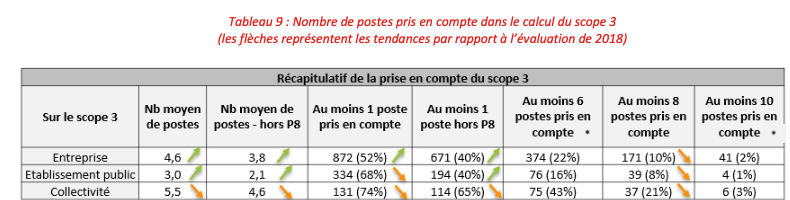

### 3.2.2.4. L’intensité carbone dans les bilans publiés sur la plateforme

In [23]:
# tableau 12, p.33
secteurs_intensifs = [
    "Industrie du papier et du carton",
    "Cokéfaction et raffinage",
    "Fabrication d'autres produits minéraux non métalliques",
    "Métallurgie",
    "Industrie chimique",
    "Production et distribution d'électricité, de gaz, de vapeur et d'air conditionné",
    "Transports terrestres et transport par conduites",
    "Transports aériens",
]
len(secteurs_intensifs)

8

In [24]:
df.Id.nunique()

5409

In [25]:
all_naf2 = df.naf2.unique().tolist()
len(all_naf2)

82

In [26]:
all(s in all_naf2 for s in secteurs_intensifs)

True

In [27]:
y[LABELS.type_structure].unique()

array(['Entreprise/Association', 'Collectivité territoriale (dont EPCI)',
       'Établissement public'], dtype=object)

In [28]:
x = df.copy()
x['scope3'] = ~x[LABELS.poste_emissions].str.startswith(('1.', '2.'))
x['secteur_intensif'] = x.naf2.isin(secteurs_intensifs)
x['type_structure_with_secteur'] = x.apply(
    lambda y: f'{y[LABELS.type_structure]}-secteur_intensif={y["secteur_intensif"]}' if y[LABELS.type_structure] == 'Entreprise/Association' else y[LABELS.type_structure],
    axis='columns'
)
x = x.groupby(['type_structure_with_secteur', 'scope3', 'Id'])[LABELS.emissions_par_salarie].sum()

In [29]:
x.groupby(['type_structure_with_secteur', 'Id']).sum().groupby('type_structure_with_secteur').mean()

type_structure_with_secteur
Collectivité territoriale (dont EPCI)            225.573074
Entreprise/Association-secteur_intensif=False    141.055067
Entreprise/Association-secteur_intensif=True     465.884730
Établissement public                              13.272560
Name: Émission_par_salarié, dtype: float64

In [30]:
x.groupby(['type_structure_with_secteur', 'scope3']).mean()

type_structure_with_secteur                    scope3
Collectivité territoriale (dont EPCI)          False     146.780315
                                               True       78.792759
Entreprise/Association-secteur_intensif=False  False      32.102752
                                               True      108.952315
Entreprise/Association-secteur_intensif=True   False     365.415318
                                               True      100.469413
Établissement public                           False       8.276485
                                               True        4.996075
Name: Émission_par_salarié, dtype: float64

Not toooo far !

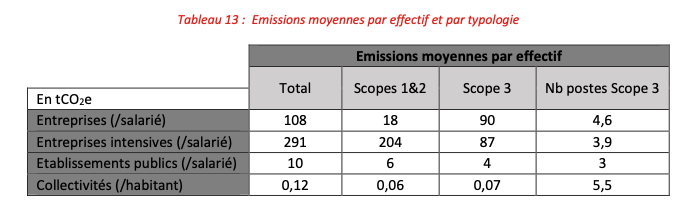

And what if I use the entire dataset? Figures are slightly higher, but still same order of magnitude !

In [31]:
df = benchmark.get_df().copy()
df.loc[df[LABELS.type_structure].isin(['Entreprise', 'Association']), LABELS.type_structure] = 'Entreprise/Association'
x = df
x['scope3'] = ~x[LABELS.poste_emissions].str.startswith(('1.', '2.'))
x['secteur_intensif'] = x.naf2.isin(secteurs_intensifs)
x['type_structure_with_secteur'] = x.apply(
    lambda y: f'{y[LABELS.type_structure]}-secteur_intensif={y["secteur_intensif"]}' if y[LABELS.type_structure] == 'Entreprise/Association' else y[LABELS.type_structure],
    axis='columns'
)
x = x.groupby(['type_structure_with_secteur', 'scope3', 'Id'])[LABELS.emissions_par_salarie].sum()

In [32]:
x.groupby(['type_structure_with_secteur', 'Id']).sum().groupby('type_structure_with_secteur').mean()

type_structure_with_secteur
Collectivité territoriale (dont EPCI)            225.573074
Entreprise/Association-secteur_intensif=False    141.055067
Entreprise/Association-secteur_intensif=True     465.884730
Établissement public                              13.272560
État                                               3.897653
Name: Émission_par_salarié, dtype: float64

In [33]:
x.groupby(['type_structure_with_secteur', 'scope3']).mean()

type_structure_with_secteur                    scope3
Collectivité territoriale (dont EPCI)          False     146.780315
                                               True       78.792759
Entreprise/Association-secteur_intensif=False  False      32.102752
                                               True      108.952315
Entreprise/Association-secteur_intensif=True   False     365.415318
                                               True      100.469413
Établissement public                           False       8.276485
                                               True        4.996075
État                                           False       1.483524
                                               True        2.414129
Name: Émission_par_salarié, dtype: float64

In [34]:
177 / 5.3

33.39622641509434